# Binary Classifier on Single records

### Most basic example.
This notebook will show how to set-up the features, read them from a CSV file and create a very simple feed-forward neural net to classify fraud vs. non-fraud

## Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

# Set up device 

In [2]:
print(f'Torch Version : {torch.__version__}')

# Set up the GPU if available. This will be the default device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Cuda Version  : {torch.version.cuda}')
    print(f'GPU found. Using GPU {device}')
else:
    device = torch.device('cpu')
    print(f'No GPU found ... Using CPU {device}')

# Also set up a cpu device
cpu = torch.device('cpu')

Torch Version : 1.6.0
Cuda Version  : 10.2
GPU found. Using GPU cuda


## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [3]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object

In [4]:
# Change this to read from another location
file = '../../../../data/bs140513_032310.csv'

In [5]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

base_features = ft.TensorDefinition(
    'base', 
    [
        age,
        gender,
        merchant,
        category,
        amount,
        fraud
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_csv(base_features, file, inference=False)
    
df

2020-10-24 11:13:13.451 d373c7.engines.common          INFO     Start Engine...
2020-10-24 11:13:13.452 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-10-24 11:13:13.452 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-10-24 11:13:13.452 d373c7.engines.panda_numpy     INFO     Building Panda for : base from file ../../../../data/bs140513_032310.csv
2020-10-24 11:13:13.651 d373c7.engines.panda_numpy     INFO     Building Panda for : <base> from DataFrame. Inference mode <False>
2020-10-24 11:13:13.657 d373c7.engines.panda_numpy     INFO     Done creating base. Shape=(594643, 6)


,age,gender,merchant,category,amount,fraud
0,4,M,M348934600,es_transportation,4.55,0
1,2,M,M348934600,es_transportation,39.68,0
2,4,F,M1823072687,es_transportation,26.89,0
3,3,M,M348934600,es_transportation,17.25,0
4,5,M,M348934600,es_transportation,35.72,0
...,...,...,...,...,...,...
594638,3,F,M1823072687,es_transportation,20.53,0
594639,4,F,M1823072687,es_transportation,50.73,0
594640,2,F,M349281107,es_fashion,22.44,0
594641,5,M,M1823072687,es_transportation,14.46,0


## Define some derived features
After we've defined the source feature, we can define some derived features. Derived features apply a form of logic to the source features. The logic depends on the type of feature. The derived features can be created using the `EnginePandasNumpy` using the `from_df` method. 
The `from_df` method returns a Pandas DataFrame

In [6]:
amount_scale = ft.FeatureNormalizeScale('amount_scale', ft.FEATURE_TYPE_FLOAT_32, amount)
age_oh = ft.FeatureOneHot('age_one_hot', age)
gender_oh = ft.FeatureOneHot('gender_one_hot', gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', merchant)
category_oh = ft.FeatureOneHot('category_one_hot', category)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_scale,
        fraud
    ])

with en.EnginePandasNumpy() as e:
    df = e.from_df(learning_features, df, inference=False)
df

2020-10-24 11:13:24.058 d373c7.engines.common          INFO     Start Engine...
2020-10-24 11:13:24.058 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-10-24 11:13:24.058 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-10-24 11:13:24.058 d373c7.engines.panda_numpy     INFO     Building Panda for : <learning> from DataFrame. Inference mode <False>
2020-10-24 11:13:24.143 d373c7.engines.panda_numpy     INFO     Create amount_scale Normalize/Scale amount. Min. 0.00 Max. 8329.96
2020-10-24 11:13:24.182 d373c7.engines.panda_numpy     INFO     Done creating learning. Shape=(594643, 79)


,age__0,age__1,age__2,age__3,age__4,age__5,age__6,age__U,gender__E,gender__F,...,category__es_hyper,category__es_leisure,category__es_otherservices,category__es_sportsandtoys,category__es_tech,category__es_transportation,category__es_travel,category__es_wellnessandbeauty,amount_scale,fraud
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.000546,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.004764,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0.003228,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0.002071,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0.004288,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594638,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0.002465,0
594639,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0.006090,0
594640,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0.002694,0
594641,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0.001736,0


## Convert to Numpy
Define which of the fields will be the label.

Then convert the panda to a list of Numpy arrays. The list will have an entry for each of the Learning types. It will split out the Binary, Continuous, Categorical and Label. Each Learning type will have a list entry

This step is needed so the models understand how to use the variables 

In [7]:
learning_features.set_label(fraud)
with en.EnginePandasNumpy() as e:
    data_list = e.to_numpy_list(learning_features, df)
print(data_list.shapes)
print(data_list.dtype_names)

2020-10-24 11:13:27.742 d373c7.engines.common          INFO     Start Engine...
2020-10-24 11:13:27.742 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.2
2020-10-24 11:13:27.742 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2020-10-24 11:13:27.743 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2020-10-24 11:13:27.743 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Binary
2020-10-24 11:13:27.766 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: float32
2020-10-24 11:13:27.766 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Continuous
2020-10-24 11:13:27.768 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2020-10-24 11:13:27.768 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Label


[(594643, 77), (594643,), (594643,)]
['int8', 'float32', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. This way the training, validation and test data are nicely colocated in time

> 1. Split out a training-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.



In [8]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list
gc.collect()
print('Done')

Training Data shapes [(464643, 77), (464643,), (464643,)]
Validation Data shapes [(30000, 77), (30000,), (30000,)]
Test Data shapes [(100000, 77), (100000,), (100000,)]
Done


# Start Training

> The training data set has to be balanced for Neural Nets. To do this, the fraud class will be aggressively upsampled in the training phase by a custom `ClassSampler`. It oversamples the minority label until it matches the majority label. This may not be a good idea for a really large data sets.

In [15]:
# Setup Pytorch Datasets for the training and validation
train_ds = pt.NumpyListDataSet(learning_features, train_data)
val_ds = pt.NumpyListDataSet(learning_features, val_data)
train_sampler = pt.ClassSampler(train_data,learning_features).over_sampler()
val_sampler = pt.ClassSampler(val_data,learning_features).over_sampler()

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, 128, num_workers=2, sampler=train_sampler)
val_dl = val_ds.data_loader(cpu, 128, num_workers=2, sampler=val_sampler)

# Create a Model
m = pm.FeedForwardFraudClassifier(learning_features)
print(m)

FeedForwardFraudClassifier(
  (head): TensorDefinitionHead(lcs=['Binary', 'Continuous'])
  (linear): LinDropAct(
    (layers): Sequential(
      (0): Linear(in_features=78, out_features=16, bias=True)
      (1): ReLU(inplace=True)
    )
  )
  (out): SingleClassBinaryOutput(
    (out_block): Sequential(
      (0): Linear(in_features=16, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
)


2020-10-24 11:17:45.429 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 100 steps: 100%|██████████| 100/100 [00:00<00:00, 342.53it/s]
2020-10-24 11:17:45.729 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


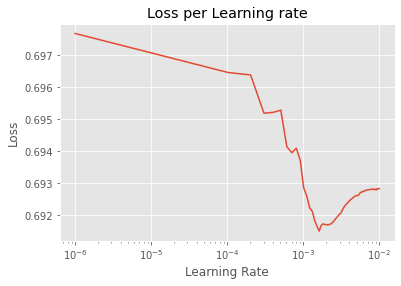

In [22]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-6, 1e-2, 100)
pl.TrainPlot().plot_lr(r)

Epoch 010/010: 100%|██████████| 3866/3866 [00:05<00:00, 662.92it/s, train_acc=0.977, train_loss=0.0566, val_acc=0.981, val_loss=0.0443]


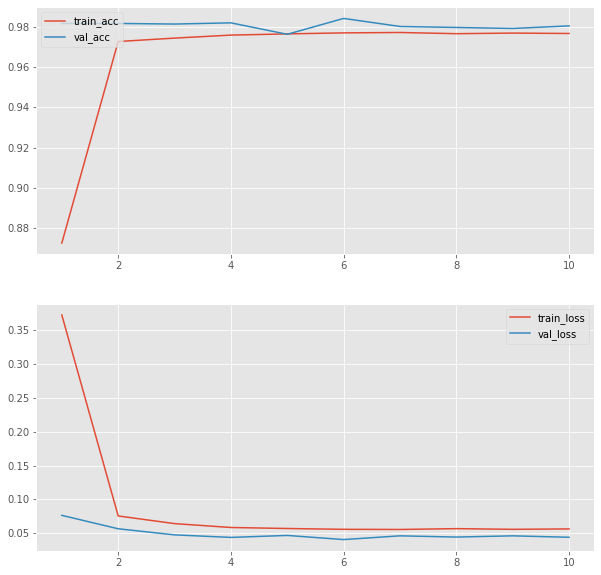

In [23]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(10, 1e-3)
pl.TrainPlot().plot_history(*h, fig_size=(10,10))

# Test the model on the test data

In [32]:
test_ds = pt.NumpyListDataSet(learning_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
pr = ts.test_plot()

Testing in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 798.29it/s]


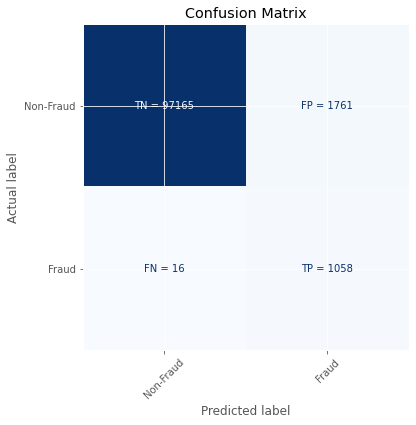

In [33]:
pl.TestPlot().plot_confusion_matrix(*pr, fig_size=(6,6))

In [34]:
pl.TestPlot().print_classification_report(*pr)

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     98926
         1.0       0.38      0.99      0.54      1074

    accuracy                           0.98    100000
   macro avg       0.69      0.98      0.77    100000
weighted avg       0.99      0.98      0.99    100000


auc score : 0.9986
ap score  : 0.9149
-----------------------------------------------------
